# 1. 프로젝트 목표 및 목적

T P E
- T: 진료내역정보(성별, 나이, 주소, 병명, 병원, 입원일 등) 여러 사항을 고려하여 수진자(서울시) 병원비(본인 부담금)을 예측한다.
- P : Random Forest(Grid Search, Randomized Grid Search) 및 SVM(Bayes Grid Search) 적용
- E : 수진자들에 대한 기본정보(성, 연령대)와 진료내역(진료과목코드, 주상병코드, 요양일수, 총처방일수 등)으로 구성된 정보를 통한 학습(건강보험공단에서 제공한 개방데이터)

# 2. 관련 데이터 수집
- 공공데이터포털 https://data.go.kr/data/15007115/fileData.do 의 2018년 진료 내역 정보(진료내역정보(2018)_20191217.zip)

## 항목별 세부 사항

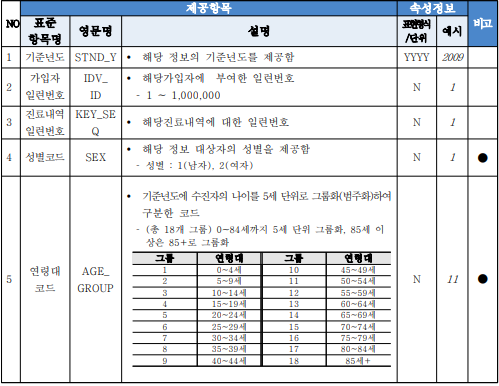

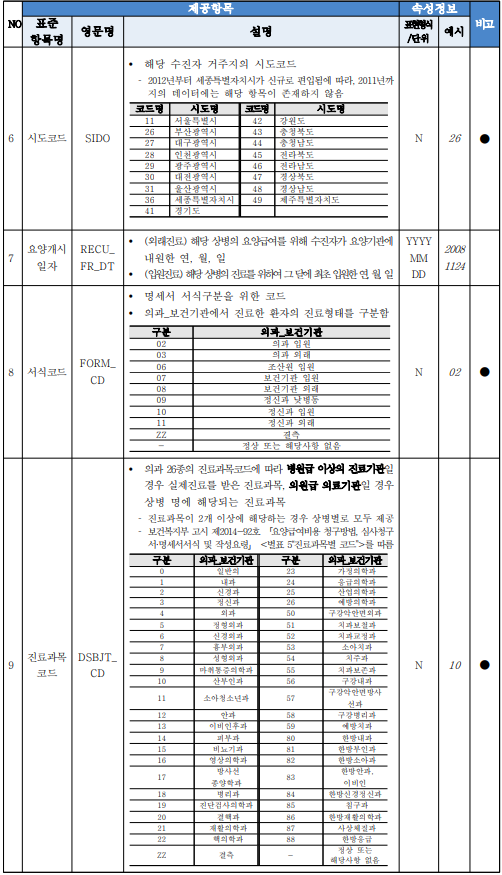

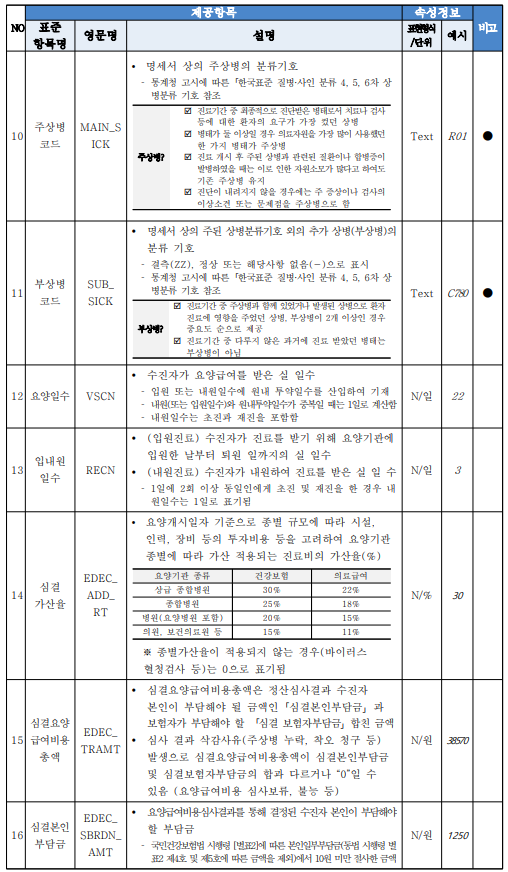

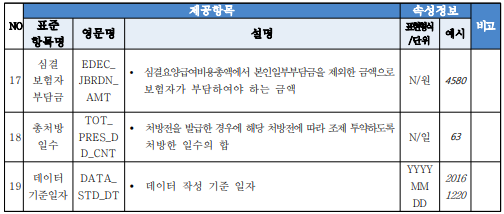

#### 질병 코드(Main_Sick) 각각은 https://nhiss.nhis.or.kr/bd/ad/bdada038cv.do 에서 검색할 수 있다.

## 사용할 항목(column) 선택

1. 기준 년도 : 제거(2018)
2. 가입자 일련번호 : 제거 -> 같은 사람의 진료라도 개별적인 것으로 처리. 
3. 진료 내역일련번호 : 제거
4. 성별 코드 : **사용**
5. 연령대 코드 : **사용**
6. 시도 코드 : **사용**(서울시만)
7. 요양 개시일 : **미사용**(아프기 시작한 날이므로 날씨, 외부 환경 등에 연관성 있을 수 있다. but 적용 힘들어 일단 제거)
8. 서식 코드 : **사용**(*결측치 제거 필요*. 임의로 대체하기 어려움)
9. 진료 과목 코드 : **사용**(*class*로 바꿔줄 필요가 있다)
10. 주상병 코드 : **사용**(*class*로 바꿔줄 필요가 있다.)
11. 부상병 코드 : 제거 
  - 병이 3개 이상이라면 부상병의 기준을 알 수 없다.
  - one-hot encoding 시에 약 5000개 이상이 추가되어 컴퓨터 환경 상 학습을 하기 어렵다.
  - 주상병코드 하나만 사용하는 것에 비해 일관성이 떨어질 수 있다는 이유로 제거
12. 요양일수 : **사용**
13. 입내원일수 : **사용**
14. 심결 가산율 : **사용**(상급 종합 병원(0.3), 종합 병원(0.25), 병원,요양병원(0.2), 의원, 보건의료원(0.15) 등 시설, 인력, 장비 등에 따른 결과값이 나올 것이라고 생각된다. 또한 비율(%)로 진료비를 가산하므로 영향이 있을 것이다.)
15. 심결 요양 급여비용 총액 : 제거 (심결 요양 급여비용 총액 = 병원비(심결 본인 부담금) + 심결 보험자 부담금)
16. 병원비(심결 본인 부담금) : **사용**(*결과값*으로 사용)
17. 심결 보험자 부담금 : 제거
18. 총 처방 일수 : **사용**
19. 데이터 기준 일자 : 제거

- 15, 17은 16의 결과값과 직접적으로 연관이 있기 때문에 제거한다.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib의 기본 scheme 대신에 seaborn scheme, font setting
plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

## 데이터셋 가져오기

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
cd /content/gdrive/MyDrive/Colab Notebooks/진료내역정보를 통한 수진자 본인 부담금 예측

/content/gdrive/MyDrive/Colab Notebooks/진료내역정보를 통한 수진자 본인 부담금 예측


In [4]:
col = ['Year', 'ID', 'Key_SEQ', 'Sex', 'Age_Group', 'SIDO', 'Recu_FR_DT', 'FORM_CD', 'DSBJT_CD',
       'Main_Sick', 'Sub_Sick', 'Days', 'RECN', 'EDEC_ADD_RT', 'EDEC_TRAMT', 'EDEC_SBRDN_AMT', 'EDEC_JBRDN_AMT', 'TOT_PRES_DD_CNT', 'dataday']

- 메모리 부족으로 인해 3개의 파일을 모두 사용하는데 어려움이 있었다.
  - 파일 1개(약 455만개 진료 기록)가 충분한 데이터 양이며
  - 서식코드, 진료과목 코드에 결측치가 없어 해당하는 feature로 정렬된 값인가 하여 전체 데이터로 실습해보았으나 data2, data3에도 결측치가 존재하지 않아 편향이 거의 존재하지 않는다고 하여 파일 1개('NHIS_OPEN_T20_2018_PART1.csv')로 진행하였다.

In [5]:
df = pd.read_csv('NHIS_OPEN_T20_2018_PART1.csv', names = col, encoding = 'unicode_escape')

# data2 = pd.read_csv('NHIS_OPEN_T20_2018_PART2.csv', names = col, encoding = 'unicode_escape')
# data3 = pd.read_csv('NHIS_OPEN_T20_2018_PART3.csv', names = col, encoding = 'unicode_escape')

In [6]:
# df = df.append(data2)
# df = df.append(data3)

In [7]:
# del data2
# del data3

In [8]:
df

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
0,±âÁØ³âµµ,°¡ÀÔÀÚÀÏ·Ã¹øÈ£,Áø·á³»¿ªÀÏ·Ã¹øÈ£,¼ºº°ÄÚµå,¿¬·É´ëÄÚµå,½ÃµµÄÚµå,¿ä¾ç°³½ÃÀÏÀÚ,¼­½ÄÄÚµå,Áø·á°ú¸ñÄÚµå,ÁÖ»óº´ÄÚµå,ºÎ»óº´ÄÚµå,¿ä¾çÀÏ¼ö,ÀÔ³»¿øÀÏ¼ö,½É°á°¡»êÀ²,½É°á¿ä¾ç±Þ¿©ºñ¿ëÃÑ¾×,½É°áº»ÀÎºÎ´ã±Ý,½É°áº¸ÇèÀÚºÎ´ã±Ý,ÃÑÃ³¹æÀÏ¼ö,µ¥ÀÌÅÍ±âÁØÀÏÀÚ
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217


# 3. 데이터 전처리

## 데이터 확인 및 변경

In [9]:
df.head()

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
0,±âÁØ³âµµ,°¡ÀÔÀÚÀÏ·Ã¹øÈ£,Áø·á³»¿ªÀÏ·Ã¹øÈ£,¼ºº°ÄÚµå,¿¬·É´ëÄÚµå,½ÃµµÄÚµå,¿ä¾ç°³½ÃÀÏÀÚ,¼­½ÄÄÚµå,Áø·á°ú¸ñÄÚµå,ÁÖ»óº´ÄÚµå,ºÎ»óº´ÄÚµå,¿ä¾çÀÏ¼ö,ÀÔ³»¿øÀÏ¼ö,½É°á°¡»êÀ²,½É°á¿ä¾ç±Þ¿©ºñ¿ëÃÑ¾×,½É°áº»ÀÎºÎ´ã±Ý,½É°áº¸ÇèÀÚºÎ´ã±Ý,ÃÑÃ³¹æÀÏ¼ö,µ¥ÀÌÅÍ±âÁØÀÏÀÚ
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217


In [10]:
# 0행 제거
df = df.drop([0])

In [11]:
df.tail()

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217
4550673,2018,350000,7494484,2,12,41,20180312,3,6,M4806,M4316,1,1,0.3,39690,29600,10090,0,20191217


In [12]:
df

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217
5,2018,2,31225816,2,4,28,20181002,03,13,J42,J303,1,1,0.15,10950,3200,7750,5,20191217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217


### 사용하지 않을 Feature 삭제

In [13]:
# df.drop(['Year', 'ID', 'Key_SEQ', 'EDEC_TRAMT', 'EDEC_JBRDN_AMT', 'dataday'], axis = 1, inplace = True)
df.drop(['Year', 'ID', 'Key_SEQ', 'Recu_FR_DT', 'Sub_Sick', 'EDEC_TRAMT', 'EDEC_JBRDN_AMT', 'dataday'], axis = 1, inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550673 entries, 1 to 4550673
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Sex              object
 1   Age_Group        object
 2   SIDO             object
 3   FORM_CD          object
 4   DSBJT_CD         object
 5   Main_Sick        object
 6   Days             object
 7   RECN             object
 8   EDEC_ADD_RT      object
 9   EDEC_SBRDN_AMT   object
 10  TOT_PRES_DD_CNT  object
dtypes: object(11)
memory usage: 416.6+ MB


- Main_Sick, Sub_Sick의 질병 정보 등으로 인해 one-hot encoding 시 데이터 양이 매우 늘어나 학습이 어려울 것이라고 예상되어 **'서울시'** 만 조사.

In [15]:
# SIDO = 11 : 서울시
df = df[df['SIDO'] == 11]

In [16]:
df.reset_index(drop = True, inplace = True)

In [17]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
0,2,8,11,3,1,J209,1,1,0.15,4500,5
1,2,8,11,3,1,J303,1,1,0.15,5100,5
2,1,1,11,3,12,H5222,1,1,0.2,31300,0
3,1,1,11,3,12,H5222,1,1,0.2,11800,0
4,1,1,11,3,12,H5309,1,1,0.15,12000,0
...,...,...,...,...,...,...,...,...,...,...,...
813871,2,18,11,3,1,I109,1,1,0.15,1900,30
813872,2,18,11,3,1,I70990,1,1,0.15,1500,15
813873,2,18,11,3,1,I70990,1,1,0.15,1500,30
813874,2,18,11,3,1,I70990,1,1,0.15,1500,30


### 결측치 제거

- 서식 코드('FORM_CD')의 결측치 'ZZ'는 보건기관을 임의로 정해서 대체하기 어려우며 해당하는 데이터 외에도 정보가 많다고 판단하여 제거
- 진료과목 코드('DSBJT_CD')의 결측치 'ZZ' 또한 진료과목을 임의로 정해서 대체하기 어려우며 해당하는 데이터 외에도 정보가 많다고 판단하여 제거

In [18]:
# 해당 데이터안에는 결측치가 없음
print(df[df['FORM_CD'] == 'ZZ'])
print(df[df['DSBJT_CD'] == 'ZZ'])

Empty DataFrame
Columns: [Sex, Age_Group, SIDO, FORM_CD, DSBJT_CD, Main_Sick, Days, RECN, EDEC_ADD_RT, EDEC_SBRDN_AMT, TOT_PRES_DD_CNT]
Index: []
Empty DataFrame
Columns: [Sex, Age_Group, SIDO, FORM_CD, DSBJT_CD, Main_Sick, Days, RECN, EDEC_ADD_RT, EDEC_SBRDN_AMT, TOT_PRES_DD_CNT]
Index: []


In [19]:
# 결측치가 없으므로 주석 처리
# need_del = df[df['FORM_CD'] == 'ZZ'].index
# df.drop(need_del, axis = 0, inplace = True)
# need_del2 = df[df['DSBJT_CD'] == 'ZZ'].index
# df.drop(need_del2, axis = 0, inplace = True)

### 타입 변환

- 두 항목은 int, float로 하여 서로 독립적으로 판단하지 않아도 된다고 판단하였다.
  - 성별(1, 2)
  - 나이 그룹(0 ~ 85세 이상 -> 1 ~ 18)
  - 심결가산율(상급 종합병원(0.3), 종합병원(0.25), 병원, 요양병원(0.2), 의원, 보건의료원(0.15) : 심결가산율(건강보험공단 기준 인력과 장비의 수준에 따른 진료비 가산율)이 병원의 수준을 적절하게 나타낸다고 가정.



In [20]:
# df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].astype('int')
# df['Age_Group'] = df['Age_Group'].astype('category') 
df['Age_Group'] = df['Age_Group'].astype('int') 
# df['EDEC_ADD_RT'] = df['EDEC_ADD_RT'].astype('category')
df['EDEC_ADD_RT'] = df['EDEC_ADD_RT'].astype('float')

In [21]:
df['RECN'] = df['RECN'].astype('int')
df['Days'] = df['Days'].astype('int')
df['EDEC_SBRDN_AMT'] = df['EDEC_SBRDN_AMT'].astype('int')
df['TOT_PRES_DD_CNT'] = df['TOT_PRES_DD_CNT'].astype('int')

In [22]:
df['FORM_CD'] = df['FORM_CD'].astype('category') 
df['DSBJT_CD'] = df['DSBJT_CD'].astype('category')
df['Main_Sick'] = df['Main_Sick'].astype('category')

In [23]:
FORM_CD = set(df['FORM_CD'])
print(FORM_CD)
print(len(FORM_CD))

DSBJT_CD = set(df['DSBJT_CD'])
print(DSBJT_CD)
print(len(DSBJT_CD))

Main_Sick = set(df['Main_Sick'])
print(Main_Sick)
print(len(Main_Sick))

{8, 2, 3}
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 50, 55, 80, 85}
30
{'M4300', 'S333', 'L719', 'C229', 'K869', 'S541', 'Q692', 'H0429', 'S609', 'D759', 'B338', 'K614', 'S8630', 'S100', 'M3212', 'M4800', 'L244', 'M9495', 'N2888', 'S3210', 'D152', 'K2591', 'L852', 'M4392', 'M4790', 'M2319', 'K592', 'S62621', 'I483', 'M9426', 'M7288', 'L259', 'H0452', 'J849', 'M350', 'M4316', 'K859', 'H1624', 'M5440', 'I6350', 'L959', 'M4729', 'N311', 'J152', 'C930', 'D1720', 'J4480', 'S969', 'M4895', 'L258', 'L291', 'G545', 'H163', 'M_', 'M6263', 'K274', 'H6501', 'H66', 'S5290', 'M06999', 'M05899', 'T221', 'Z733', 'M06899', 'S52591', 'M6586', 'Z853', 'S5341', 'M2423', 'S8628', 'S27209', 'H1181', 'H1105', 'I256', 'R431', 'J014', 'I129', 'M8280', 'M6260', 'R227', 'M6213', 'M6793', 'H2521', 'C3489', 'M7796', 'S6360', 'D411', 'Z048', 'E1470', 'I251', 'T159', 'S6540', 'H66011', 'L5088', 'H406', 'D3001', 'I7381', 'S1013', 'M7192', 'H441', 'T2305', 'H4019

### 충분한 데이터가 있는 병(Main_Sick)만 사용
- Main_Sick 의 종류가 너무 많아서(5191개) 데이터 내에 각 병명의 총 개수가 3000개 이하로 표본이 전체 경우를 대표하기 힘든 경우 및 자주 비교적 자주 발생되지 않는 병의 경우는 제외한다.
  - 즉, exist 리스트에 존재하는 병명만 남긴다. (총 5191개의 병 중에서 **45개**의 병이 남고 전체 진료 데이터의 **약 48.2%**가 남게 된다.)
- 병이 너무 많으면 너무 많은 데이터가 존재하기 때문에 시각화를 통해 어떤 병이 병원비가 많이 나오는 병인지를 구분하기 어렵다.

In [24]:
df['Main_Sick'].value_counts()

J209     69964
I109     41488
F_       23128
N_       17820
E119     12323
         ...  
L00          1
L0101        1
E248         1
L023         1
A029         1
Name: Main_Sick, Length: 5191, dtype: int64

In [25]:
sick = list(Main_Sick)

In [26]:
exist = []
needdel = []

In [27]:
for i in range(len(sick)):
  if len(df[df['Main_Sick'] == sick[i]]) > 3000:
    exist.append(sick[i])
  else:
    needdel.append(sick[i])

In [28]:
len(exist)

45

In [29]:
data = pd.DataFrame()
data = data.append(df[df['Main_Sick'] == exist[0]])
for i in range(1, len(exist)):
  data = data.append(df[df['Main_Sick'] == exist[i]])
df = data

In [30]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
151,2,14,11,3,1,J459,1,1,0.30,135800,30
152,2,14,11,3,1,J459,1,1,0.30,177200,0
153,2,14,11,3,1,J459,1,1,0.30,77700,30
155,2,14,11,3,1,J459,1,1,0.30,30500,90
156,2,14,11,3,1,J459,1,1,0.30,30500,90
...,...,...,...,...,...,...,...,...,...,...,...
813132,2,2,11,3,13,J0390,1,1,0.15,2400,3
813299,1,5,11,3,13,J0390,1,1,0.15,8700,4
813620,2,7,11,3,1,J0390,1,1,0.15,10200,4
813633,2,7,11,3,1,J0390,1,1,0.15,5100,3


In [31]:
df.reset_index(drop = True, inplace = True)

In [32]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
0,2,14,11,3,1,J459,1,1,0.30,135800,30
1,2,14,11,3,1,J459,1,1,0.30,177200,0
2,2,14,11,3,1,J459,1,1,0.30,77700,30
3,2,14,11,3,1,J459,1,1,0.30,30500,90
4,2,14,11,3,1,J459,1,1,0.30,30500,90
...,...,...,...,...,...,...,...,...,...,...,...
392784,2,2,11,3,13,J0390,1,1,0.15,2400,3
392785,1,5,11,3,13,J0390,1,1,0.15,8700,4
392786,2,7,11,3,1,J0390,1,1,0.15,10200,4
392787,2,7,11,3,1,J0390,1,1,0.15,5100,3


- One-hot Encoding되지 않은 전체적인 연관관계를 시각화하기 위해 미리 저장

In [33]:
correldation = df.corr()

### One-hot Encoding 적용
- 서식 코드(FORM_CD) # **종류 : 3**
- 진료과목코드(DSBJT_CD) # **종류 : 30**
- 주상병코드(Main_Sick) # **종류 : 45** ( 3000개 이상의 정보가 있는 주상병만 추린 데이터 )

위 세 항목은 각 항목 내 요소끼리의 연관성이 없어 one-hot encoding 적용 필요한 범주형이라고 판단하였다.

- 서식 코드(FORM_CD) One-hot Encoding

In [34]:
F = pd.get_dummies(df.FORM_CD, prefix = 'FORM_CD')
F

,FORM_CD_2,FORM_CD_3,FORM_CD_8
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
392784,0,1,0
392785,0,1,0
392786,0,1,0
392787,0,1,0


- 진료과목코드(DSBJT_CD) One-hot Encoding

In [35]:
D = pd.get_dummies(df.DSBJT_CD, prefix = 'DFBJT_CD')
D

,DFBJT_CD_0,DFBJT_CD_1,DFBJT_CD_2,DFBJT_CD_3,DFBJT_CD_4,DFBJT_CD_5,DFBJT_CD_6,DFBJT_CD_7,DFBJT_CD_8,DFBJT_CD_9,DFBJT_CD_10,DFBJT_CD_11,DFBJT_CD_12,DFBJT_CD_13,DFBJT_CD_14,DFBJT_CD_15,DFBJT_CD_16,DFBJT_CD_17,DFBJT_CD_19,DFBJT_CD_20,DFBJT_CD_21,DFBJT_CD_22,DFBJT_CD_23,DFBJT_CD_24,DFBJT_CD_25,DFBJT_CD_26,DFBJT_CD_50,DFBJT_CD_55,DFBJT_CD_80,DFBJT_CD_85
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392784,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392785,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392786,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392787,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- 주상병코드(Main_Sick) One-hot Encoding

In [36]:
for i in range(len(needdel)):
  needdel[i] = "Main_Sick_" + needdel[i]

In [37]:
needdel

['Main_Sick_M4300',
 'Main_Sick_S333',
 'Main_Sick_L719',
 'Main_Sick_C229',
 'Main_Sick_K869',
 'Main_Sick_S541',
 'Main_Sick_Q692',
 'Main_Sick_H0429',
 'Main_Sick_S609',
 'Main_Sick_D759',
 'Main_Sick_B338',
 'Main_Sick_K614',
 'Main_Sick_S8630',
 'Main_Sick_S100',
 'Main_Sick_M3212',
 'Main_Sick_M4800',
 'Main_Sick_L244',
 'Main_Sick_M9495',
 'Main_Sick_N2888',
 'Main_Sick_S3210',
 'Main_Sick_D152',
 'Main_Sick_K2591',
 'Main_Sick_L852',
 'Main_Sick_M4392',
 'Main_Sick_M4790',
 'Main_Sick_M2319',
 'Main_Sick_K592',
 'Main_Sick_S62621',
 'Main_Sick_I483',
 'Main_Sick_M9426',
 'Main_Sick_M7288',
 'Main_Sick_L259',
 'Main_Sick_H0452',
 'Main_Sick_J849',
 'Main_Sick_M350',
 'Main_Sick_M4316',
 'Main_Sick_K859',
 'Main_Sick_H1624',
 'Main_Sick_M5440',
 'Main_Sick_I6350',
 'Main_Sick_L959',
 'Main_Sick_M4729',
 'Main_Sick_N311',
 'Main_Sick_J152',
 'Main_Sick_C930',
 'Main_Sick_D1720',
 'Main_Sick_J4480',
 'Main_Sick_S969',
 'Main_Sick_M4895',
 'Main_Sick_L258',
 'Main_Sick_L291',
 'Main

In [38]:
M_S = pd.get_dummies(df.Main_Sick, prefix = 'Main_Sick')
M_S = M_S.drop(columns = needdel, axis = 1)
M_S

,Main_Sick_A090,Main_Sick_A099,Main_Sick_A_,Main_Sick_B_,Main_Sick_E119,Main_Sick_F_,Main_Sick_H0411,Main_Sick_H101,Main_Sick_I109,Main_Sick_J00,Main_Sick_J0190,Main_Sick_J029,Main_Sick_J0390,Main_Sick_J040,Main_Sick_J042,Main_Sick_J060,Main_Sick_J069,Main_Sick_J209,Main_Sick_J219,Main_Sick_J303,Main_Sick_J304,Main_Sick_J329,Main_Sick_J40,Main_Sick_J459,Main_Sick_J_,Main_Sick_K210,Main_Sick_K219,Main_Sick_K291,Main_Sick_K297,Main_Sick_L239,Main_Sick_M170,Main_Sick_M171,Main_Sick_M4806,Main_Sick_M501,Main_Sick_M511,Main_Sick_M5422,Main_Sick_M5456,Main_Sick_M750,Main_Sick_N185,Main_Sick_N300,Main_Sick_N400,Main_Sick_N_,Main_Sick_S134,Main_Sick_S3350,Main_Sick_Z_
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392784,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392785,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392786,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392787,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df = pd.merge(df, F, left_index = True, right_index = True, how = 'left')
df = pd.merge(df, D, left_index = True, right_index = True, how = 'left')
df = pd.merge(df, M_S, left_index = True, right_index = True, how = 'left')
df


,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT,FORM_CD_2,FORM_CD_3,FORM_CD_8,DFBJT_CD_0,DFBJT_CD_1,DFBJT_CD_2,DFBJT_CD_3,DFBJT_CD_4,DFBJT_CD_5,DFBJT_CD_6,DFBJT_CD_7,DFBJT_CD_8,DFBJT_CD_9,DFBJT_CD_10,DFBJT_CD_11,DFBJT_CD_12,DFBJT_CD_13,DFBJT_CD_14,DFBJT_CD_15,DFBJT_CD_16,DFBJT_CD_17,DFBJT_CD_19,DFBJT_CD_20,DFBJT_CD_21,DFBJT_CD_22,DFBJT_CD_23,DFBJT_CD_24,DFBJT_CD_25,DFBJT_CD_26,...,Main_Sick_F_,Main_Sick_H0411,Main_Sick_H101,Main_Sick_I109,Main_Sick_J00,Main_Sick_J0190,Main_Sick_J029,Main_Sick_J0390,Main_Sick_J040,Main_Sick_J042,Main_Sick_J060,Main_Sick_J069,Main_Sick_J209,Main_Sick_J219,Main_Sick_J303,Main_Sick_J304,Main_Sick_J329,Main_Sick_J40,Main_Sick_J459,Main_Sick_J_,Main_Sick_K210,Main_Sick_K219,Main_Sick_K291,Main_Sick_K297,Main_Sick_L239,Main_Sick_M170,Main_Sick_M171,Main_Sick_M4806,Main_Sick_M501,Main_Sick_M511,Main_Sick_M5422,Main_Sick_M5456,Main_Sick_M750,Main_Sick_N185,Main_Sick_N300,Main_Sick_N400,Main_Sick_N_,Main_Sick_S134,Main_Sick_S3350,Main_Sick_Z_
0,2,14,11,3,1,J459,1,1,0.30,135800,30,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,14,11,3,1,J459,1,1,0.30,177200,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,14,11,3,1,J459,1,1,0.30,77700,30,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,14,11,3,1,J459,1,1,0.30,30500,90,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,14,11,3,1,J459,1,1,0.30,30500,90,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392784,2,2,11,3,13,J0390,1,1,0.15,2400,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392785,1,5,11,3,13,J0390,1,1,0.15,8700,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392786,2,7,11,3,1,J0390,1,1,0.15,10200,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392787,2,7,11,3,1,J0390,1,1,0.15,5100,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# 기존에 있던 FORM_CD, DSBJT_CD, Main_Sick는 Drop
df.drop(['FORM_CD', 'DSBJT_CD', 'Main_Sick'], axis = 1, inplace = True)

In [41]:
df

,Sex,Age_Group,SIDO,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT,FORM_CD_2,FORM_CD_3,FORM_CD_8,DFBJT_CD_0,DFBJT_CD_1,DFBJT_CD_2,DFBJT_CD_3,DFBJT_CD_4,DFBJT_CD_5,DFBJT_CD_6,DFBJT_CD_7,DFBJT_CD_8,DFBJT_CD_9,DFBJT_CD_10,DFBJT_CD_11,DFBJT_CD_12,DFBJT_CD_13,DFBJT_CD_14,DFBJT_CD_15,DFBJT_CD_16,DFBJT_CD_17,DFBJT_CD_19,DFBJT_CD_20,DFBJT_CD_21,DFBJT_CD_22,DFBJT_CD_23,DFBJT_CD_24,DFBJT_CD_25,DFBJT_CD_26,DFBJT_CD_50,DFBJT_CD_55,DFBJT_CD_80,...,Main_Sick_F_,Main_Sick_H0411,Main_Sick_H101,Main_Sick_I109,Main_Sick_J00,Main_Sick_J0190,Main_Sick_J029,Main_Sick_J0390,Main_Sick_J040,Main_Sick_J042,Main_Sick_J060,Main_Sick_J069,Main_Sick_J209,Main_Sick_J219,Main_Sick_J303,Main_Sick_J304,Main_Sick_J329,Main_Sick_J40,Main_Sick_J459,Main_Sick_J_,Main_Sick_K210,Main_Sick_K219,Main_Sick_K291,Main_Sick_K297,Main_Sick_L239,Main_Sick_M170,Main_Sick_M171,Main_Sick_M4806,Main_Sick_M501,Main_Sick_M511,Main_Sick_M5422,Main_Sick_M5456,Main_Sick_M750,Main_Sick_N185,Main_Sick_N300,Main_Sick_N400,Main_Sick_N_,Main_Sick_S134,Main_Sick_S3350,Main_Sick_Z_
0,2,14,11,1,1,0.30,135800,30,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,14,11,1,1,0.30,177200,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,14,11,1,1,0.30,77700,30,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,14,11,1,1,0.30,30500,90,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,14,11,1,1,0.30,30500,90,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392784,2,2,11,1,1,0.15,2400,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392785,1,5,11,1,1,0.15,8700,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392786,2,7,11,1,1,0.15,10200,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392787,2,7,11,1,1,0.15,5100,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392789 entries, 0 to 392788
Data columns (total 86 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              392789 non-null  int64  
 1   Age_Group        392789 non-null  int64  
 2   SIDO             392789 non-null  object 
 3   Days             392789 non-null  int64  
 4   RECN             392789 non-null  int64  
 5   EDEC_ADD_RT      392789 non-null  float64
 6   EDEC_SBRDN_AMT   392789 non-null  int64  
 7   TOT_PRES_DD_CNT  392789 non-null  int64  
 8   FORM_CD_2        392789 non-null  uint8  
 9   FORM_CD_3        392789 non-null  uint8  
 10  FORM_CD_8        392789 non-null  uint8  
 11  DFBJT_CD_0       392789 non-null  uint8  
 12  DFBJT_CD_1       392789 non-null  uint8  
 13  DFBJT_CD_2       392789 non-null  uint8  
 14  DFBJT_CD_3       392789 non-null  uint8  
 15  DFBJT_CD_4       392789 non-null  uint8  
 16  DFBJT_CD_5       392789 non-null  uint

In [43]:
df.describe()

,Sex,Age_Group,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT,FORM_CD_2,FORM_CD_3,FORM_CD_8,DFBJT_CD_0,DFBJT_CD_1,DFBJT_CD_2,DFBJT_CD_3,DFBJT_CD_4,DFBJT_CD_5,DFBJT_CD_6,DFBJT_CD_7,DFBJT_CD_8,DFBJT_CD_9,DFBJT_CD_10,DFBJT_CD_11,DFBJT_CD_12,DFBJT_CD_13,DFBJT_CD_14,DFBJT_CD_15,DFBJT_CD_16,DFBJT_CD_17,DFBJT_CD_19,DFBJT_CD_20,DFBJT_CD_21,DFBJT_CD_22,DFBJT_CD_23,DFBJT_CD_24,DFBJT_CD_25,DFBJT_CD_26,DFBJT_CD_50,DFBJT_CD_55,DFBJT_CD_80,DFBJT_CD_85,...,Main_Sick_F_,Main_Sick_H0411,Main_Sick_H101,Main_Sick_I109,Main_Sick_J00,Main_Sick_J0190,Main_Sick_J029,Main_Sick_J0390,Main_Sick_J040,Main_Sick_J042,Main_Sick_J060,Main_Sick_J069,Main_Sick_J209,Main_Sick_J219,Main_Sick_J303,Main_Sick_J304,Main_Sick_J329,Main_Sick_J40,Main_Sick_J459,Main_Sick_J_,Main_Sick_K210,Main_Sick_K219,Main_Sick_K291,Main_Sick_K297,Main_Sick_L239,Main_Sick_M170,Main_Sick_M171,Main_Sick_M4806,Main_Sick_M501,Main_Sick_M511,Main_Sick_M5422,Main_Sick_M5456,Main_Sick_M750,Main_Sick_N185,Main_Sick_N300,Main_Sick_N400,Main_Sick_N_,Main_Sick_S134,Main_Sick_S3350,Main_Sick_Z_
count,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,3.927890e+05,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.0,392789.000000,392789.0,392789.000000,...,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000,392789.000000
mean,1.595427,9.423405,1.084463,1.877774,0.160588,1.023749e+04,10.167209,0.007864,0.987321,0.004814,0.004919,0.429167,0.003737,0.049945,0.011029,0.097424,0.012337,0.000418,0.000064,0.012778,0.060396,0.061575,0.021620,0.156860,0.015268,0.020138,0.000349,0.000023,0.000109,0.000092,0.006882,0.000008,0.030345,0.004417,0.000013,0.000066,0.0,0.000020,0.0,0.000003,...,0.058881,0.011716,0.010296,0.105624,0.020739,0.019076,0.030686,0.028988,0.019766,0.008857,0.020752,0.014417,0.178121,0.008763,0.015723,0.027045,0.010565,0.016699,0.008631,0.015062,0.018552,0.012276,0.009769,0.011721,0.016508,0.023033,0.007796,0.019486,0.009293,0.018476,0.009944,0.016238,0.008847,0.017702,0.008773,0.010003,0.045368,0.007793,0.013083,0.008923
std,0.490810,5.023237,1.442218,5.345637,0.034216,4.569963e+04,19.320892,0.088331,0.111883,0.069218,0.069961,0.494958,0.061020,0.217832,0.104438,0.296534,0.110387,0.020429,0.007978,0.112315,0.238220,0.240382,0.145439,0.363669,0.122616,0.140473,0.018673,0.004787,0.010462,0.009573,0.082669,0.002764,0.171534,0.066315,0.003568,0.008136,0.0,0.004513,0.0,0.001596,...,0.235403,0.107606,0.100944,0.307356,0.142509,0.136794,0.172465,0.167772,0.139197,0.093695,0.142552,0.119204,0.382615,0.093200,0.124404,0.162215,0.102244,0.128140,0.092499,0.121798,0.134936,0.110116,0.098352,0.107629,0.127417,0.150008,0.087948,0.138227,0.095949,0.134664,0.099224,0.126389,0.093642,0.131865,0.093253,0.099513,0.208110,0.087933,0.113632,0.094041
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000

## 연관관계(상관관계)


#### 주요 6가지 특징

- 병원비(본인 부담금, EDEC_SBRDN_AMT)와 
    - 성별(Sex)
    - 나이(Age_Group)
    - 입원일 수 + 원내에서 투약(주사 등)받은 일 수(Days)
    - 입원일 수(RECN)
    - 병원 등급에 따른 가산율(EDEC_SBRDN_AMT)
    - 처방전에 따라 투약하도록 한 일 수(TOT_PRES_DD_CNT)
    
의 연관관계

- 위의 5가지 항목만 뽑아서 시각화하였다.
    

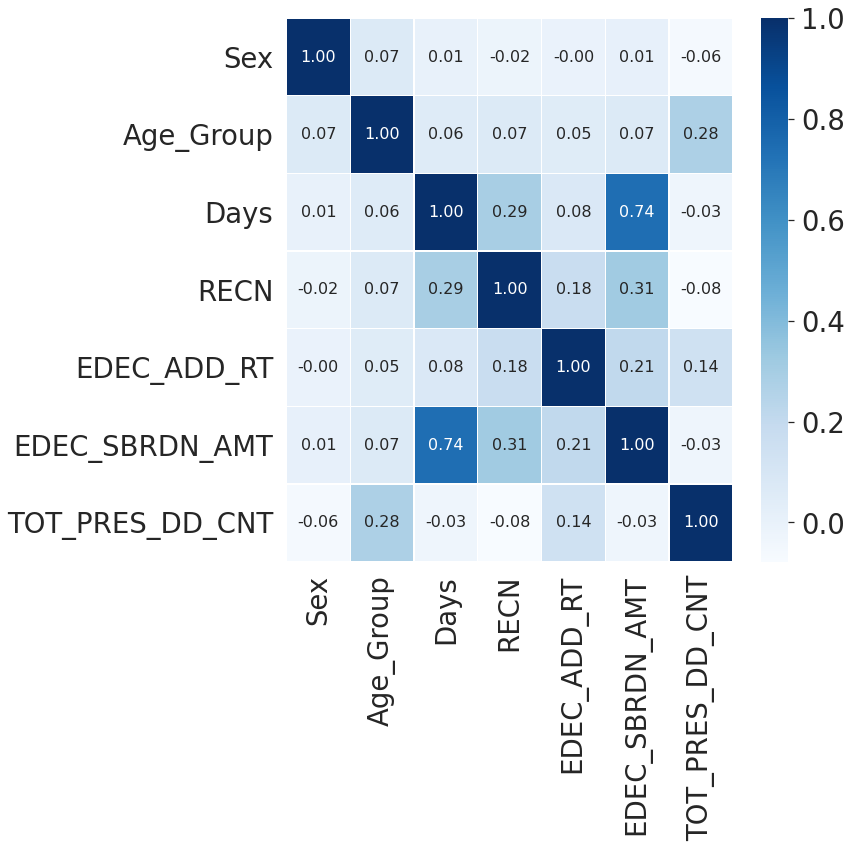

In [44]:
f, ax = plt.subplots(figsize = (10, 10))
mask = np.zeros_like(correldation)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correldation, annot = True, linewidths = 0.4, linecolor = 'white', fmt = '.2f', ax = ax, cmap = 'Blues', annot_kws={'size':16})
plt.show()

- 성별(Sex) : **0.01**
    - 병원비가 성별에 따라 차이가 나지는 않았다.(0.01을 무관하다고 보았다.)
- 나이(Age_Group) : **0.07**
    - 병원비가 나이와 조금은 연관관계가 존재하는 것을 확인할 수 있었다.
- 입원일 수 + 원내에서 투약(주사 등)받은 일 수(Days) : **0.74**
    - 입원을 하거나, 병원에서 투약을 받는 등 병원에서 이루어지는 의료를 받은 일 수가 결과와 가장 큰 영향이 있는 것을 알 수 있었다.
- 입원일 수(RECN) : **0.31**
    - 병원비가 입원일과 연관관계가 있음을 알 수 있었다.
- 병원 등급에 따른 가산율(EDEC_SBRDN_AMT) : **0.21**
    - 상급 종합병원, 종합 병원, 병원(요양 병원), 의원(보건의료원)에 따라 진료비에 비율(%)로 가산하는 만큼 Days 다음으로 영향이 큰 것을 확인할 수 있었다.
- 처방전에 따라 투약하도록 한 일 수(TOT_PRES_DD_CNT) : **-0.03**
    - 투약 일수는 병원비와 크게 영향이 없다는 것을 확인할 수 있었다.

#### 기타 특징(서식코드(진료 형태), 병명, 병원 수준 등)
- 양의 상관관계 0.05 이상 혹은 음의 상관관계 -0.05 이하인 것들만 주요 특징으로 정리

In [45]:
corrdf = df.corr()

In [46]:
corrdf = pd.DataFrame(corrdf)

##### 양의 상관관계
- 병원비와 양의 상관관계가 가장 높은 20가지의 특징을 추출하였다

In [47]:
corrdf = corrdf['EDEC_SBRDN_AMT'].sort_values(ascending = False)
corrdf[1:21] # [0]은 자기자신이므로 제외

Days               0.741673
FORM_CD_2          0.581679
RECN               0.314112
EDEC_ADD_RT        0.212167
Main_Sick_F_       0.142260
DFBJT_CD_3         0.076591
Age_Group          0.066452
DFBJT_CD_2         0.055069
DFBJT_CD_24        0.052783
Main_Sick_M170     0.044986
DFBJT_CD_6         0.043797
Main_Sick_B_       0.043440
DFBJT_CD_10        0.041514
Main_Sick_N_       0.041127
Main_Sick_N185     0.040688
DFBJT_CD_5         0.024703
Main_Sick_Z_       0.021329
DFBJT_CD_21        0.019320
Main_Sick_M4806    0.017075
Main_Sick_M171     0.016878
Name: EDEC_SBRDN_AMT, dtype: float64


- 2번째로 양의 상관관계가 높은 **FORM_CD_2**(약 **0.58**의 높은 양의 상관관계)는 진료형태가 `의과 입원`인 것을 나타내는 서식 코드이다.
  - 연관관계가 높은 Days, FORM_CD_2, RECN 모두 입원과 관련이 있는 걸 보아 병원비와 입원은 가장 큰 양의 상관관계가 있음을 알 수 있다.



- 5번째로 양의 상관관계가 높은 Main_Sick_F_(질병코드 : **F_**, 약 **0.14**의 양의 상관관계)는 `치매, 우울증, 자폐 등 정신, 심리적 장애`이다.
  - 정신, 심리적 장애인 환자는 대부분 입원과 관계가 있기 때문에 병원비와 양의 상관관계가 높게 나타난 것으로 유추해볼 수 있다.


- 6번째로 양의 상관관계가 높은 **DFBJT_CD_3**(약 **0.07**의 양의 상관관계)은 진료과목이 `정신과`인 것을 나타내는 진료 과목 코드이다.
  - 정신, 심리적 장애가 있는 환자는 대부분 입원과 관계가 있기 때문에 병원비와 양의 상관관계가 높게 나타난 것으로 유추해볼 수 있다.

- 8번째로 양의 상관관계가 높은 **DFBJT_CD_2**(약 **0.05**의 양의 상관관계)은 진료과목이 
`신경과`인 것을 나타내는 진료 과목 코드이다.
  - 정신, 심리적 장애가 있는 환자는 대부분 입원과 관계가 있기 때문에 병원비와 양의 상관관계가 높게 나타난 것으로 유추해볼 수 있다.

In [48]:
# 5, 6, 8번째가 입원(RECN)이 평균보다 많다는 것을 코드로

- 9번째로 양의 상관관계가 높은 **DFBJT_CD_24**(약 **0.05**의 양의 상관관계)는 진료과목이 `응급의학과`인 것을 나타내는 진료 과목 코드이다.
  - 응급환자, 응급실을 이용한 환자는 병원비가 많이 나올 것임을 유추할 수 있다.

##### 음의 상관관계
- 병원비와 음의 상관관계가 가장 높은 20가지의 특징을 추출하였다
  - DFBJT_CD_80(한방 내과), DFBJT_CD_50(구강약안면외과)는 해당하는 데이터가 없으므로 3번째 것부터 뽑아내었다.)

In [49]:
corrdf[-3:-23:-1] 

FORM_CD_3         -0.450293
Main_Sick_J209    -0.063663
DFBJT_CD_1        -0.049932
DFBJT_CD_13       -0.049276
Main_Sick_I109    -0.036630
DFBJT_CD_11       -0.029579
TOT_PRES_DD_CNT   -0.026112
Main_Sick_J0390   -0.021036
Main_Sick_J029    -0.020818
Main_Sick_J304    -0.019192
Main_Sick_J00     -0.018998
Main_Sick_J060    -0.018030
Main_Sick_J0190   -0.017542
Main_Sick_J040    -0.017196
Main_Sick_L239    -0.015800
Main_Sick_J069    -0.015226
Main_Sick_J303    -0.014557
FORM_CD_8         -0.014452
DFBJT_CD_0        -0.014426
DFBJT_CD_14       -0.014379
Name: EDEC_SBRDN_AMT, dtype: float64

- 1번째로 음의 상관관계가 높은 **FORM_CD_3**(약 **-0.45**의 높은 음의 상관관계)은 `의과 외래`를 나타내는 서식 코드이다.
  - 외래 환자는 24시간 미만 입원하는 환자로, 장기간 입원하지 않기 때문에 음의 상관관계가 높게 나타난 것으로 유추할 수 있다.

- 2번째로 음의 상관관계가 높은 Main_Sick_J209(질병코드 : **J209**, 약 **-0.06**의 음의 상관관계)는 `상세 불명의 급성 기관지염`으로 https://m.health.chosun.com/svc/news_view.html?contid=2016022403365를 참고하면 '급성 기관지염'은 외래 진료가 대부분이라 음의 상관관계가 높게 나타난 것으로 유추할 수 있다.

In [50]:
# 급성 기관지염이 외래진료가 평균보다 많다는 것을 코드로

# 4. 머신러닝을 위한 데이터 전처리

In [51]:
# Train/Test split
from sklearn.model_selection import train_test_split
# 본인 부담금 : cost
cost = df['EDEC_SBRDN_AMT']
df.drop('EDEC_SBRDN_AMT', axis = 1, inplace = True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392789 entries, 0 to 392788
Data columns (total 85 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              392789 non-null  int64  
 1   Age_Group        392789 non-null  int64  
 2   SIDO             392789 non-null  object 
 3   Days             392789 non-null  int64  
 4   RECN             392789 non-null  int64  
 5   EDEC_ADD_RT      392789 non-null  float64
 6   TOT_PRES_DD_CNT  392789 non-null  int64  
 7   FORM_CD_2        392789 non-null  uint8  
 8   FORM_CD_3        392789 non-null  uint8  
 9   FORM_CD_8        392789 non-null  uint8  
 10  DFBJT_CD_0       392789 non-null  uint8  
 11  DFBJT_CD_1       392789 non-null  uint8  
 12  DFBJT_CD_2       392789 non-null  uint8  
 13  DFBJT_CD_3       392789 non-null  uint8  
 14  DFBJT_CD_4       392789 non-null  uint8  
 15  DFBJT_CD_5       392789 non-null  uint8  
 16  DFBJT_CD_6       392789 non-null  uint

In [53]:
# Train에 필요한 Data가 충분하다고 판단하여 90 : 10로 나누었다. 
# 9:1 결과 : array([0.76457081, 0.73878535, 0.83749241, 0.61893041, 0.79342399])
# 8:2 결과 : array([0.79046766, 0.76677832, 0.72897169, 0.71894388, 0.72883849])
X_train, X_test, y_train, y_test = train_test_split(df, cost, test_size = 0.1, random_state = 42)

In [54]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(353510, 85) (39279, 85) (353510,) (39279,)


### 데이터 표준화

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 5-1 학습(RandomForest)

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

- 기본 모델(Baseline)

In [57]:
basic_forest = RandomForestRegressor(n_jobs = -1, random_state = 42)

In [58]:
basic_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

- cross_val_score도 random_state를 지정해서 동일한 결과값이 나오도록 해야 한다.

In [59]:
cross_val_score(estimator = basic_forest, X = X_test_scaled, y = y_test, cv = 5)

array([0.71211385, 0.74457887, 0.6968574 , 0.34479723, 0.82616941])

- GridSearch를 통해 찾아낸 Hyperparameter를 적용하였다.

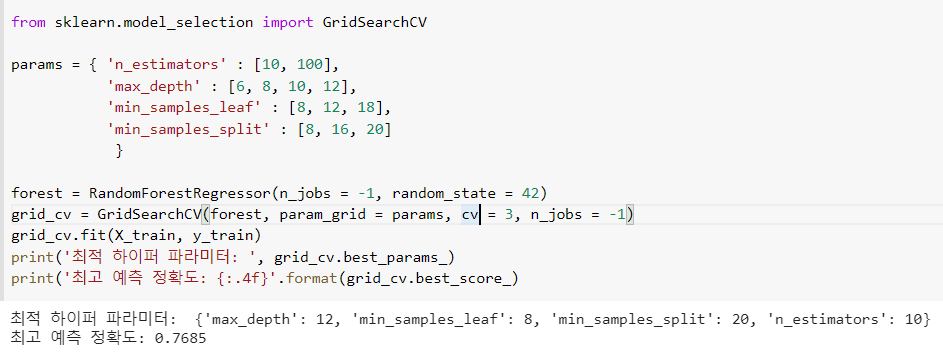

In [60]:
from sklearn.model_selection import GridSearchCV
# 주석 처리

# params = { 'n_estimators' : [10, 100],
#            'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [8, 12, 18],
#            'min_samples_split' : [8, 16, 20]
#             }

forest = RandomForestRegressor(n_estimators = 10, max_depth = 12, min_samples_leaf = 8, min_samples_split = 20, n_jobs = -1, random_state = 42)
# grid_cv = GridSearchCV(forest, param_grid = params, cv = 3, n_jobs = -1)
# grid_cv.fit(X_train, y_train)
# print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_)

In [61]:
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [62]:
cross_val_score(estimator = forest, X = X_test_scaled, y = y_test, cv = 5)

array([0.71185861, 0.71157747, 0.70537109, 0.6335603 , 0.70773292])

# 6-1 평가 및 튜닝(RandomForest)

### Grid Search를 적용하여 Hyperparameter 조정

- Random Forest의 적절한 하이퍼 파라미터를 그리드 탐색을 통해서 찾아냈다.
  - 후보군을 얼마 넣지 않았는데도 그리드 탐색의 시간이 너무 오래 걸려(2시간 이상) 많은 대상을 넣어서 최적의 성능을 보이는 결과를 찾아내기는 시간적으로 여유가 없었다.

#### Hyperparameter Tuning 결과
- 기본 모델(Hyperparameter X)
  - 평균 성능 0.64
- GridSearch 적용 모델
  - 평균 성능 0.7


- 다른 방법 적용의 필요성을 느껴 적용해보았다(Randomized Grid Search)

## Randomized Grid Search

- 일일이 추려낸 hyperparameter를 통해 괜찮았던 것들만 param에 추가하여 Randomized grid search를 적용해보았다.
  - n_estimators = [5, 10, 20, 40]
  - max_depth는 성능에 큰 영향을 미치지 못하는 것으로 판단하여 parameter에 추가하지 않았다. 
    - 12로 결정
  - min_samples_leaf = [1, 2, 3, 4, 5]
  - min_samples_split 또한 성능에 큰 영향을 미치지 못하는 것으로 판단하여 param에 추가하지 않았다 
    - 20으로 결정
  - max_features를 추가하였다.


In [63]:
# # 시간이 오래 걸려 주석 처리
# from sklearn.model_selection import RandomizedSearchCV

# params = { 'n_estimators' : [10, 20, 40],
#             'min_samples_leaf' : [1, 2, 3],
#             'max_features' : [10, 20, 30, 40, 50]}

# rfr = RandomForestRegressor(n_jobs = -1, random_state = 42)
# randomized_search_rfr = RandomizedSearchCV(rfr, params, n_iter = 30, cv = 5,
#                                            return_train_score = True)
# randomized_search_rfr.fit(X_train, y_train)
# print('최적 하이퍼 파라미터: ', randomized_search_rfr.best_params_)
# # print('최고 예측 정확도: {:.4f}'.format(randomized_search_rfr.best_score_)

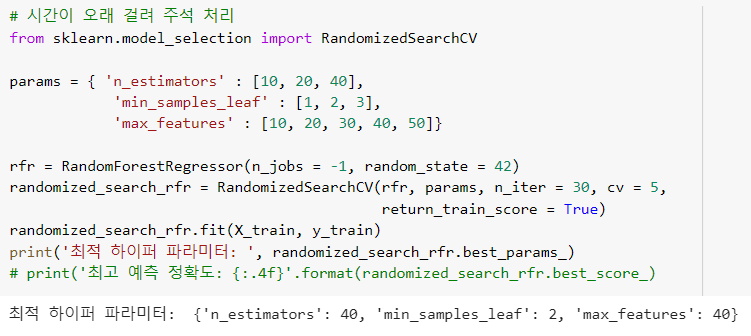

- RandomizedSearchCV를 적용한 Hyperparameter를 RandomForestRegressor에 적용해보았다.

In [64]:
forest3 = RandomForestRegressor(n_estimators = 40, max_depth = 12, min_samples_leaf = 2, min_samples_split = 20, max_features = 40, n_jobs = -1, random_state = 42)

In [65]:
forest3.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [66]:
cross_val_score(estimator = forest3, X = X_test_scaled, y = y_test, cv = 5)

array([0.73585218, 0.71580875, 0.6879189 , 0.71149575, 0.7339186 ])

## 최종 모델
  - 평균적인 성능이 가장 성능이 뛰어난 모델(Randomized Grid Search)를 이용한 모델
    - 평균 성능 0.71

In [67]:
Final_forest = forest3

In [68]:
Final_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [69]:
cross_val_score(estimator = Final_forest, X = X_test_scaled, y = y_test, cv = 5)

array([0.73585218, 0.71580875, 0.6879189 , 0.71149575, 0.7339186 ])

- 시간이 충분하다면 GridSearchCV를 이용하여 hyperparameter 범위를 늘여서 학습해보았다면 좋은 모델을 찾을 수 있었을 것이라고 생각된다.

## Feature Importance

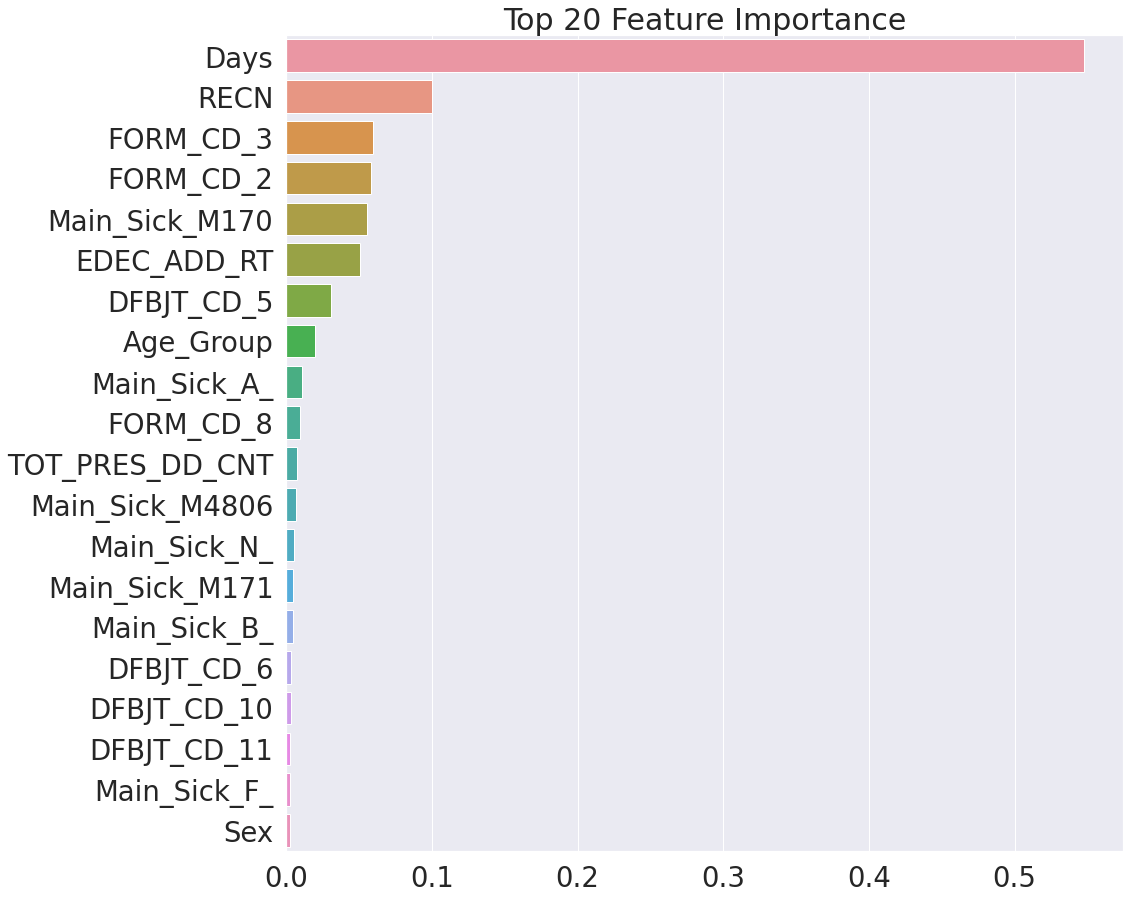

In [70]:
importances_value = Final_forest.feature_importances_
importances = pd.Series(importances_value, index = X_train.columns)
top20 = importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (15, 15))
plt.title('Top 20 Feature Importance')
sns.barplot(x = top20, y = top20.index)
plt.show()

In [71]:
top20[:10]

Days              0.547448
RECN              0.100278
FORM_CD_3         0.059241
FORM_CD_2         0.057950
Main_Sick_M170    0.055143
EDEC_ADD_RT       0.050227
DFBJT_CD_5        0.030706
Age_Group         0.019923
Main_Sick_A_      0.010352
FORM_CD_8         0.009347
dtype: float64

#### 분기를 나누는 중요한 요인 (0.05이상인 것, 소수 둘째자리까지 반올림)



- Days(입원 및 병원 내 투약) : **0.55**
- Main_Sick_M170(질병 코드 : M170, 양쪽 일차성 무릎 관절증) : **0.09**
  - 외래 환자
- FORM_CD_3(의과 외래) : **0.06**
- FORM_CD_2(의과 입원) : **0.06**
- Main_Sick_M171(질병 코드 : M171, 기타 일차성 무릎 관절증) : **0.05**
- EDEC_ADD_RT(심결 가산율(병원 수준)) : **0.05**




# 5-2 학습(SVM)

In [72]:
from sklearn.svm import SVR

- 기본 모델(Baseline)

In [73]:
svr = SVR(kernel = 'rbf', gamma = 'scale', max_iter = 1000, C = 0.3)

In [74]:
svr.fit(X_train_scaled, y_train)

SVR(C=0.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=1000, shrinking=True, tol=0.001, verbose=False)

In [76]:
cross_val_score(estimator = svr, X = X_test_scaled, y = y_test, cv = 5)

array([-0.09985752, -0.04590552, -0.06945233, -0.10260231, -0.02575623])

In [77]:
!pip install scikit-optimize

In [ ]:
# # 시간이 오래 걸려 주석처리
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer


# params = {
#     'gamma' : (0.05, 0.5, 0.1),
#     'C' : (0.05, 0.5, 0.1),
# }
# svr = SVR(kernel = 'rbf', max_iter = 5000)

# bayes_search_svr = BayesSearchCV(svr, params, n_iter = 5, cv = 5,
#                                          random_state = 42)
# bayes_search_svr.fit(X_train_scaled, y_train)

# print('최적 하이퍼 파라미터: ', bayes_search_rfr.best_params_)

In [ ]:
# cross_val_score(estimator = bayes_search_svr, X = X_test_scaled, y = y_test, cv = 5)